In [143]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import Video

rho = 0.05
p = 10000
omega = 1
beta = 0.27
tau = 0.5
T = 15

xi = 1/np.sqrt(rho)

$dt = e^{-\tau \omega t} \frac{Q_t}{Q_0}$

In [144]:
def compute_dt(t, Qt, Q0):
    v1 = np.exp(-tau*omega*t)
    v2 = Qt/Q0
    return v1*v2

$\lambda_t = Q_t (1-e^{-\tau \omega t})$

In [145]:
def compute_lmbt(t, Qt):
    return Qt * (1-np.exp(-tau*omega*t))

$\sigma^2_t = 1-Q_t^2 \bigg[1+\big(\frac{1}{Q_0^2}-1\big)e^{-2\tau \omega t} \bigg]$

In [146]:
def compute_sgmt(t, Qt, Q0):
    v1 = 1 + (np.power(Q0, -2)-1)*np.exp(-2*tau*omega*t)
    v2 = np.square(Qt)
    
    return np.sqrt(1-v2*v1)

$x_t \mid \xi = dtx_0 + \sigma_tu + \lambda_t\xi$  
$u \stackrel{i.i.d}{\sim} \mathcal{N}(0, 1)$

In [147]:
def compute_x(t, x0, Q0): 
    Qt = compute_Q(t, Q0)
    dt = compute_dt(t, Qt, Q0)
    lmbt = compute_lmbt(t, Qt)
    sgmt = compute_sgmt(t, Qt, Q0)
        
    return dt*x0 + sgmt*np.random.randn(*sgmt.shape) + lmbt*xi

For Gaussian initialization

$\mathbb{E}[x_t \mid \xi] = (dtQ_0 + \lambda_t)\xi$  
$\mathbb{E}[x_t^2 \mid \xi] = dt^2(1-Q_0^2) + \sigma_t^2$ ==> **The $dt^2$ part is missing in the document!**

In [164]:
def gauss_params(ts, Q0):    
    Qt = compute_Q(ts, Q0)
    dt = compute_dt(ts, Qt, Q0)
    lmbt = compute_lmbt(ts, Qt)
    sgmt = compute_sgmt(ts, Qt, Q0)
    
    means = (dt*Q0 + lmbt)*xi
    stds = np.sqrt((1 - np.square(Q0))*np.square(dt) + np.square(sgmt))
    
    return means, stds

In [149]:
def compute_Q(t, Q0):
    q1 = tau*omega*(1+0.5*tau)
    q2 = tau*(omega-0.5*tau)
    
    if q2 == 0:
        val = 1/(np.power(Q0, -2) + q1*t)
    else:
        val = q2 / ((q1 - (q1-q2*np.power(Q0, -2))*np.exp(-2*q2*t)))
        
    return np.sqrt(val)

#### Some utility functions

In [150]:
def animator(xs, ts, X_mc, pdfs, fps=30, fast_forward=2):
    fig, ax = plt.subplots(figsize=(13, 5))
    bins = np.linspace(xs.min(), xs.max(), 50)

    def animate(i):
        plt.cla()
        ax.plot(xs, pdfs[i], lw=4, label='PDE', c='C3')
        ax.hist(X_mc[i], density=True, bins=bins, label='MC', color='C0', alpha=0.75, lw=1.5)
        ax.set_xlim((-5, 5))
        ax.set_ylim((0, 1))
        ax.grid()

        ax.set_xlabel("$x$")
        ax.set_ylabel(fr'''$P(x \mid \xi={round(xi, 2)})$''')
        ax.set_title(fr'''Oja Evolution from $x$ and PDE parameters (T={round(ts[i], 2)})''')
        ax.legend()

        return []
    
    interval = (ts[1] - ts[0])*1000/fast_forward
    return animation.FuncAnimation(fig, animate, frames=len(ts), interval=interval, blit=True)

#### Run the code

In [165]:
# Quantize
xs = np.linspace(-5, 5, 1000)
ts = np.linspace(0, T, 100)
dt = xs[1] - xs[0]

# Initial parameters
mean0 = 1/np.sqrt(2)
std0 = 0.5
pdf_x0 = scipy.stats.norm(loc=mean0, scale=std0).pdf(xs)

# Cosine similarity
Q0 = np.sqrt(rho)*np.dot(xs, pdf_x0)*dt
Qt = compute_Q(ts, Q0)

# Gaussian parameter evolution
means, stds = gauss_params(ts, Q0)

# PDF evolution (MC)
ntrial = 10000
x0 = np.random.randn(ntrial)*std0 + mean0
X_mc = []

for i in range(ntrial):
    X_mc.append(compute_x(ts, x0[i], Q0))

X_mc = np.array(X_mc).T
PDFs = np.zeros((len(ts), len(xs)))

for t in range(len(ts)):
    PDFs[t] = scipy.stats.norm(loc=means[t], scale=stds[t]).pdf(xs)

#### Plotting

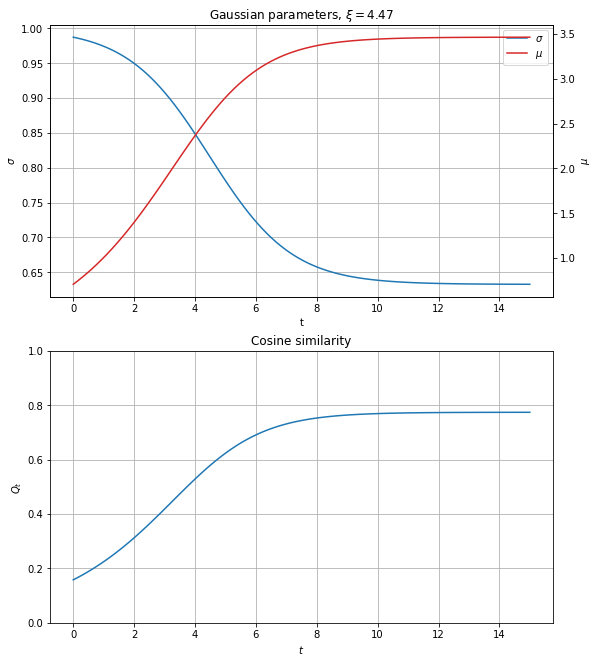

In [166]:
f, ax = plt.subplots(2, 1, figsize=(9, 11))
ax1 = ax[0]
ax12 = ax1.twinx()
ax2 = ax[1]

lns1 = ax1.plot(ts, stds, label='$\sigma$')
lns2 = ax12.plot(ts, means, label='$\mu$', c='C3')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel("t")
ax1.set_ylabel("$\sigma$")
ax12.set_ylabel("$\mu$")

ax1.set_title(fr'''Gaussian parameters, $\xi={round(xi, 2)}$''')

ax2.plot(ts, Qt)
ax2.set_ylim(0, 1)
ax2.set_xlabel("$t$")
ax2.set_ylabel("$Q_t$")

ax1.grid()
ax2.grid()
ax2.set_title("Cosine similarity");

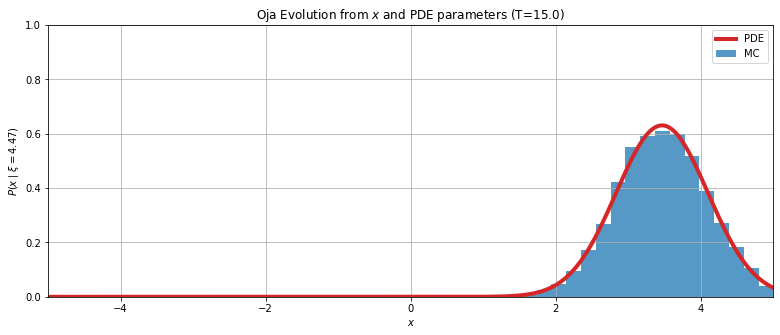

In [167]:
video = animator(xs, ts, X_mc, PDFs).to_html5_video();

In [168]:
Video(video, embed=True)

Notice that, we end up with the same final distribution but the initial distribution does not affect the change in Gaussian parameters.